# Multivariate TDE-HMM on all subjects, following Quinn's method

## Libraries and methods

In [1]:
import numpy as np
from loader import load_oneIC
import h5py
import xarray as xr

In [2]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import scale
from hmmlearn import hmm
import scipy.signal as signal
import pickle

In [3]:
import matplotlib.pyplot as plt
import matplotlib.colors as colors
from wavelet_transform import wavelet_transform2

In [4]:
import mne

In [5]:
import time as tm

In [6]:
directory = "/home/INT/malfait.n/Documents/NIC_250819"
file = "FCK_LOCKED_IC_JYOTIKA_250819.mat"

path = f"{directory}/{file}"

mat_file = h5py.File(path, "r")
cells_refs = mat_file['FCK_LOCKED_IC_JYOTIKA']

n_IC = 4
n_subj = 23

In [7]:
target_dir = "tde-hmm2/test_grids/"

## Functions

In [8]:
# The embedx function copies the `x` array len(lags) times into `xe`
# with lags (i.e. time delays) between lags[0] and lags[-1] (we implement the time-delay array for the HMM).

def embedx(x, lags):
    
    Xe = np.zeros((x.shape[1], x.shape[0],  len(lags)))

    for l in range(len(lags)):
        Xe[:, :, l] = np.roll(x, lags[l], axis=0).swapaxes(0, 1)

    # Remove edges
    valid = np.ones((x.shape[0], 1), dtype=np.int8)
    valid[:np.abs(np.min(lags)), :] = 0
    valid[-np.abs(np.max(lags)):, :] = 0

    Xe = Xe[:, valid[:, 0] == 1, :]

    return Xe, valid


# The hmm_tde function finds parameters for the HMM,
# then uses them to determine the probability of presence of each found state over time.

def hmm_tde(y: np.array, n_states=3, n_iter=100, n_components=8, 
            covariance_type='full', model_type='GMMHMM', tol=0.01, n_mix=1, **kwargs):
    
    if model_type=='GMMHMM':
        model = hmm.GMMHMM(n_components=n_states, n_iter=n_iter,
                            covariance_type=covariance_type, tol=tol, n_mix=n_mix, **kwargs)
        
    elif model_type=='GaussianHMM':
        model = hmm.GaussianHMM(n_components=n_states, n_iter=n_iter,
                            covariance_type=covariance_type, tol=tol, **kwargs)
        
    elif model_type=='MultinomialHMM':
        model = hmm.MultinomialHMM(n_components=n_states, n_iter=n_iter, tol=tol, **kwargs)
    
    else: 
        return "Non-exixting model_type. Please choose 'GMMHMM' or 'GaussianHMM' or 'MultinomialHMM'. default='GMMHMM'"
        
    model.fit(y)
    gamma = model.predict_proba(y)

    return gamma, model

In [9]:
# def statesPSD(gamma, n_states, xe):

#     psd_all = np.zeros((n_states, 196))
#     for i in range(n_states):

#         # Compute PSD separately for each lag
#         tot = []
#         for seg in xe[0, gamma[:, i]> .6, :].T:
#             freqs, psd = signal.welch(x=seg, fs=256/6, nfft=1000)
#             tot.append(psd)
#         psd = np.mean(np.asarray(tot), 0)
#         imax = np.searchsorted(freqs, 50, side='right')
#         psd_all[i] = psd[:imax]
#     psd_all = np.asarray(psd_all, 0)
    
#     return psd_all

In [53]:
def statesPSD(gamma, n_states, xe):

    psd_all = []
    for i in range(n_states):

        # Compute PSD separately for each lag
        tot = []
        for seg in xe[0, gamma[:, i]>(2/3), :].T:
            freqs, psd = signal.welch(x=seg, fs=256/3, nfft=1000)
            tot.append(psd)
        psd = np.mean(np.asarray(tot), 0)
#         imax = np.searchsorted(freqs, 50, side='right')
        psd_all.append(psd)
    
    psd_all = np.asarray(psd_all)
    
    return freqs, psd_all

## Final Script

#### Model and parameters:
|_ (??delays x 4IC)  x (7s x 256Hz x Ntrials)   -----PCA-----> |_ (??components x 4IC) x (7s x 256Hz x Ntrials) -----> |_ TDE-HMM ( 1 Gaussian/state, 3 to 6 states )

In [54]:
# The parameters we change to hope for some results
lags = np.arange(-11, 11)
n_lags = lags.shape[0]
n_iter=100
n_states_max=6    # for the Hidden Markov Model
n_components=8     # For the principal component analysis
covariance_type='full'
model_type='GaussianHMM'
tol=0.01
n_mix=1
downsamp_rate = 3

In [12]:
subj_list = [i for i in range(2,9)] + [i for i in range(10,13)] + [14] + [i for i in range(16, n_subj+1)] 
                                                                            # All except subjects 1, 9, 13, 15

## Tests

In [13]:
subj = 2
freqs = np.arange(0, 50, 50/196)

In [14]:
n_states = 3

In [55]:
# Loading all data for subject{subj}, IC{IC}
print("Computing the imput matrix for the model")
datall = []
xeall = []
IC_list = []
for IC in range(1, n_IC+1):
#         try:
        data, n_trials = load_oneIC(mat_file, cells_refs, subj, IC, comp=False)
        big_timecourse = np.concatenate([data[f'raw_timecourse_256Hz'][i][::downsamp_rate] for i in range(n_trials)])
            # Downsampled to 256/3 = 85,33333Hz
        x = big_timecourse.reshape(-1, 1)
        xe, valid = embedx(x, lags)
        xeall.append(xe)
        pca = PCA(n_components=n_components)
        y = pca.fit_transform(xe[0, :, :])
        datall.append(y)
        IC_list.append(IC)
        print(f"IC{IC} loaded")
#         except:
#             pass
y = np.concatenate(datall, axis=1)

Computing the imput matrix for the model
Loading the raw timecourse
IC1 loaded
Loading the raw timecourse
IC2 loaded
Loading the raw timecourse
IC3 loaded
Loading the raw timecourse
IC4 loaded


In [56]:
xeall[0].shape

(1, 403629, 22)

In [57]:
y.shape[0]/n_trials

597.9688888888888

When you don't have the model yet:

In [58]:

print("Computing and saving the model")
gamma, model = hmm_tde(y, n_iter=n_iter, n_states=n_states, n_components=n_components, 
                        covariance_type=covariance_type, model_type=model_type, tol=tol, n_mix=n_mix)
with open(f"tde-hmm2/test_files/su{subj}All_lg{n_lags}co{n_components}st{n_states}"
    +f"{n_mix}"+model_type+"_model.pkl", "wb") as file: pickle.dump(model, file)

Computing and saving the model


In [59]:
print("Computing the PSD of each state")
psds = []
for i in range(len(IC_list)):
    freqs, psd = statesPSD(gamma, n_states, xeall[i])
    psd = psd[np.newaxis,]
    psds.append(psd)

Computing the PSD of each state


When you do have the model but want to compute the PSDs again because they are wrong (also, you have a new function to compute the PSD with a new name and fewer arguments because you got rid of everything that was useless):

In [19]:
ds = xr.open_dataset(f"tde-hmm2/test_files/su{subj}-{n_states}states_data.nc")
tcourse = ds["states_timecourse"].values
tcourse.shape

(675, 299, 3)

In [20]:
gamma = np.zeros((675*299, 3))
gamma.shape

(201825, 3)

In [21]:
for i in range(n_states):
    gamma[:,i] = tcourse[:,:,i].reshape(675*299)

In [28]:
gamma = gamma[abs(lags[0]):-lags[-1],:]
gamma.shape

(201804, 3)

In [31]:
gamma[1,0]

0.999998478220071

In [52]:
print("Computing the PSD of each state")
psds = []
for i in range(len(IC_list)):
    freqs, psd = statesPSD(gamma, n_states, xeall[i])
    psd = psd[np.newaxis,]
    psds.append(psd)

Computing the PSD of each state
50.176 128.0
50.176 128.0
50.176 128.0
50.176 128.0
50.176 128.0
50.176 128.0
50.176 128.0
50.176 128.0
50.176 128.0
50.176 128.0
50.176 128.0
50.176 128.0


In [45]:
freqs[-1]

21.333333333333332

In [41]:
psds[0].shape

(1, 3, 501)

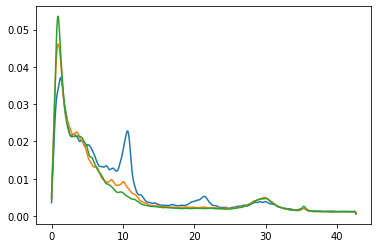

In [60]:
plt.plot(freqs, psds[0][0].T)

End of the torture

In [61]:
data["time_axis"][::downsamp_rate].shape

(598,)

In [62]:
(gamma.shape[0]+21)/n_trials

598.0

In [66]:
# Save the states timecourses and PSDs thanks to xarray and netCDF
print("Saving the states timecourses and PSDs")
tcourse = np.concatenate(
    (np.zeros((abs(lags[0]),n_states)), gamma, np.zeros((lags[-1],n_states)))
)
time_axis = data["time_axis"][::downsamp_rate]
t_len = time_axis.shape[0]
tcourse_trials = np.zeros((n_trials, t_len, n_states))
for tr in range(n_trials):
    tcourse_trials[tr] = tcourse[tr*t_len:(tr+1)*t_len]
ds = xr.Dataset(
    {
        "states_timecourse": (("trials","time", "states"), tcourse_trials),
        "states_psd": (("IC", "states", "freq"), np.concatenate((psds))),
    },
    {
        "IC":IC_list,
        "time":time_axis,
        "states":np.arange(1, n_states+1),
        "freq": freqs,
    }
)
ds.to_netcdf(f"tde-hmm2/test_files/su{subj}-{n_states}states_data.nc")
print(f"subj{subj}, IC{IC}: OK")

Saving the states timecourses and PSDs
subj2, IC4: OK


In [67]:
time_axis.shape

(598,)

In [68]:
ds

<xarray.Dataset>
Dimensions:            (IC: 4, freq: 501, states: 3, time: 598, trials: 675)
Coordinates:
  * IC                 (IC) int64 1 2 3 4
  * time               (time) float64 -4.0 -3.988 -3.977 ... 2.973 2.984 2.996
  * states             (states) int64 1 2 3
  * freq               (freq) float64 0.0 0.08533 0.1707 ... 42.5 42.58 42.67
Dimensions without coordinates: trials
Data variables:
    states_timecourse  (trials, time, states) float64 0.0 0.0 0.0 ... 0.0 0.0
    states_psd         (IC, states, freq) float64 0.003596 ... 0.0003449

In [95]:
605475/675/3

299.0

In [73]:
ds = xr.open_dataset(f"tde-hmm2/test_files/su{subj}-{n_states}states_data.nc")
ds = ds.assign(frac_occ = (ds["states_timecourse"].sum("trials")/ds.sizes["trials"]))

In [74]:
ds

<xarray.Dataset>
Dimensions:            (IC: 4, freq: 501, states: 3, time: 598, trials: 675)
Coordinates:
  * time               (time) float64 -4.0 -3.988 -3.977 ... 2.973 2.984 2.996
  * freq               (freq) float64 0.0 0.08533 0.1707 ... 42.5 42.58 42.67
  * IC                 (IC) int32 1 2 3 4
  * states             (states) int32 1 2 3
Dimensions without coordinates: trials
Data variables:
    states_timecourse  (trials, time, states) float64 0.0 0.0 0.0 ... 0.0 0.0
    states_psd         (IC, states, freq) float64 ...
    frac_occ           (time, states) float64 0.1726 0.2019 ... 0.2028 0.6292

In [75]:
ds["states"].values

array([1, 2, 3], dtype=int32)

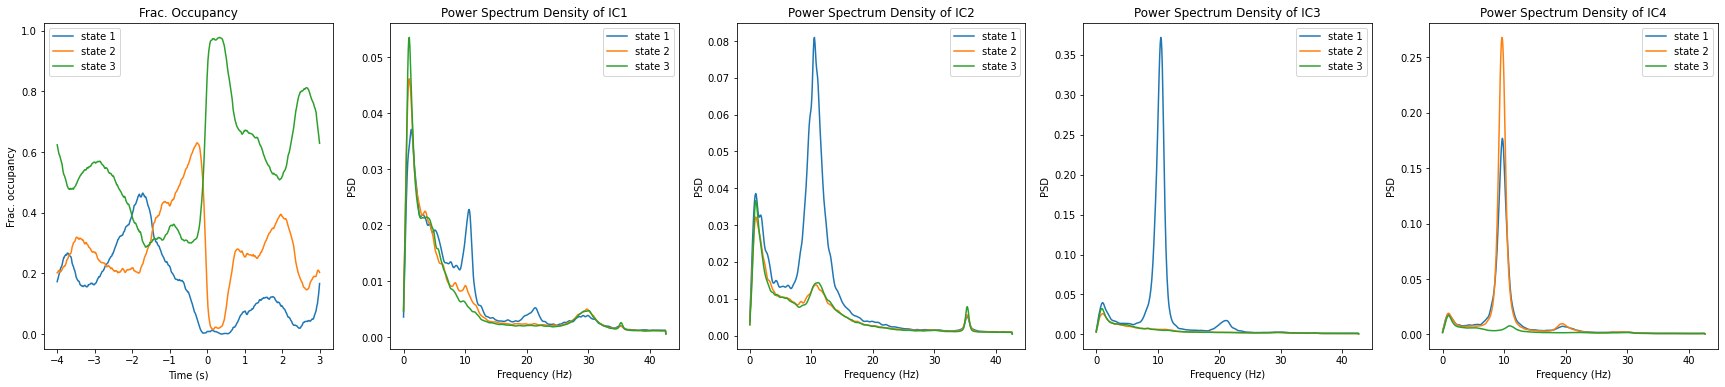

In [76]:
labels = [f"state {state}" for state in ds["states"].values]
fig = plt.figure(figsize=(6*(len(ds["IC"].values)+1),6))
plt.subplot(1, len(ds["IC"].values)+1, 1)
plt.title(f'Frac. Occupancy')
plt.plot(ds["time"].values, ds["frac_occ"].values)
plt.xlabel('Time (s)')
plt.ylabel('Frac. occupancy')
plt.legend(labels, loc='upper left')
for i in range(len(ds["IC"].values)):
    plt.subplot(1, len(ds["IC"].values)+1, i+2)
    plt.title(f"Power Spectrum Density of IC{ds['IC'].values[i]}")
    plt.plot(ds["freq"], ds["states_psd"].values[i,].T)
    plt.xlabel('Frequency (Hz)')
    plt.ylabel('PSD')
    plt.legend(labels, loc='upper right')

In [77]:
ds = xr.open_dataset(f"tde-hmm2/test_files/su{subj}-{n_states}states_data.nc")
ds = ds.assign(frac_occ = (ds["states_timecourse"].sum("trials")/ds.sizes["trials"]))
ds.to_netcdf(f"tde-hmm2/test_files/su{subj}-{n_states}states_data_Multi.nc", mode="w")
labels = [f"state {state}" for state in ds["states"].values]
fig = plt.figure(figsize=(6*(len(ds["IC"].values)+1),6))
plt.subplot(1, len(ds["IC"].values)+1, 1)
plt.title(f'Frac. Occupancy')
plt.plot(ds["time"].values, ds["frac_occ"].values)
plt.xlabel('Time (s)')
plt.ylabel('Frac. occupancy')
plt.legend(labels, loc='upper left')
for i in range(len(ds["IC"].values)):
    plt.subplot(1, len(ds["IC"].values)+1, i+2)
    plt.title(f"Power Spectrum Density of IC{ds['IC'].values[i]}")
    plt.plot(ds["freq"], ds["states_psd"].values[i,].T)
    plt.xlabel('Frequency (Hz)')
    plt.ylabel('PSD')
    plt.legend(labels, loc='upper right')
plt.savefig(f"tde-hmm2/test_png/su{subj}-frac_occ_{n_states}st_Multi.png", dpi=300)
plt.close(fig)
print(f"su{subj}, {n_states} states done")

su2, 3 states done


In [78]:
widths = [14, 1, 5]
heights = [1,1,1,4,4,4,4]

In [79]:
gs_kw = dict(width_ratios=widths, height_ratios=heights, wspace=0.0, hspace=0.0)

info = mne.create_info(ch_names=['signal'], sfreq=256, ch_types=['eeg'])

In [80]:
fig, f_axes = plt.subplots(figsize=(sum(widths),sum(heights)), ncols=3, nrows=(n_states+4), constrained_layout=True,
                         gridspec_kw=gs_kw)
ds = xr.open_dataset(f"tde-hmm2/test_files/su{subj}-{n_states}states_data_Multi.nc")
for state in ds["states"].values:
    ax = f_axes[state-1,0]
#         ax.set_xticks([])
    ax.plot(ds["time"].values, ds["frac_occ"].values[:, state-1], color=f"C{state-1}")
    ax.set_xlim([-4, 3])
    ax.set_ylabel(f"state {state}")
for IC in ds["IC"].values:
    ax = f_axes[IC+n_states-1,0]
    data, n_trials = load_oneIC(mat_file, cells_refs, subj, IC, comp=False)
    tfr = wavelet_transform2(data, info, trial=np.arange(1,n_trials+1))
    mappable = ax.imshow(tfr[0], aspect='auto', origin='lower', extent=[-4, 3, 2, 50], 
                           norm=colors.PowerNorm(gamma=0.5), cmap='RdYlBu_r')
    ax.set_ylabel(f'Frequencies IC{IC} (Hz)')
    fig.colorbar(mappable, cax=f_axes[IC+n_states-1,1])
#         if IC!=4:
#             ax.set_xticks([])
for i in range(len(ds["IC"].values)):
    IC = ds["IC"].values[i]
    ax = f_axes[IC+n_states-1,2]
    ax.plot(ds["freq"].values, ds["states_psd"].values[i,].T)
    ax.set_ylabel(f'PSD IC{IC}')
ax = f_axes[n_states,2]
lines = ax.get_lines()
labels = [f"State {i}" for i in range (1, n_states+1)]
ax = f_axes[0,2]
ax.legend(lines, labels, loc='upper left')
ax = f_axes[n_states+3,0]
ax.set_xlabel(f'Time (s)') 
ax = f_axes[n_states+3,2]
ax.set_xlabel(f'Frequency (Hz)')   

fig.savefig(target_dir + f'grid-{n_states}states-subj{subj}.png', dpi=300)
plt.close(fig)

Loading the raw timecourse
Loading the raw timecourse
Loading the raw timecourse
Loading the raw timecourse


In [82]:
n_trials_to_plot = 5

In [83]:
fig, f_axes = plt.subplots(figsize=(20,n_states*n_trials_to_plot), ncols=1, nrows=(n_states*n_trials_to_plot), constrained_layout=True)
ds = xr.open_dataset(f"tde-hmm2/test_files/su{subj}-{n_states}states_data_Multi.nc")
for state in range(1, n_states+1):
    color = f"C{state-1}"
    for trial in range(n_trials_to_plot):
        ax = f_axes[n_trials_to_plot*(state-1)+trial]
        ax.fill_between(ds["time"], ds["states_timecourse"].values[trial, :, state-1], color=color)
        ax.set_xlim([-4, 3])
        ax.set_ylim([0, 1])
        ax.set_ylabel(f"Prob. st{state} tr{trial}")
ax.set_xlabel("Time (s)")
fig.savefig(target_dir + f'tcourses-{n_states}states-subj{subj}.png', dpi=300)
plt.close(fig)